In [1]:
import numpy as np
import dask.array as da
from dask.delayed import delayed
from dask.distributed import Client
import matplotlib.pyplot as plt
import matplotlib as mpl
import ipywidgets as widgets
from ipywidgets import interactive
from scipy.optimize import least_squares
from scipy.ndimage.interpolation import zoom, shift
from scipy.interpolate import interp1d
from skimage import filters
import scipy.sparse as sp
import dask
import numba
import time

from pyL5.lib.analysis.container import Container

from Registration import *


plt.rcParams["figure.figsize"] = [12.,8.]
client = Client('localhost:8786')

In [2]:
client.upload_file('Registration.py')

def plot_stack(images, n):
    """Plot the n-th image from a stack of n images.
    For interactive use with ipython widgets"""
    im = images[n, :, :].compute()
    plt.imshow(im.T, cmap='gray', vmax=im.mean()*5)
    plt.show()

In [5]:
#TODO: Update
folder = r'.\data\20171120_160356_3.5um_591.4_IVhdr'
start, stop, stride, dE = 40, 752, 1, 10 #BF
#start, stop, stride, dE = 0, 412, 1, 10 #DF
Eslice = slice(start, stop, stride)

# Grab a window of 2*fftsize around the center of the picture
fftsize=256*2 // 2
z_factor = 1

In [6]:
original = Container(folder + '/data.h5').getStack('CPcorrected').getDaskArray()
interactive(lambda n: plot_stack(original, n), 
            n=widgets.IntSlider(1, 0, original.shape[0]-1, 1, continuous_update=False)
           ) 

C:\Users\jongt\stack\Promotie\Paperwriting\data-analysis\Code\clean-start\data\20171120_160356_3.5um_591.4_IVhdr/data.h5


interactive(children=(IntSlider(value=1, continuous_update=False, description='n', max=751), Output()), _dom_c…

In [7]:
# Step 1 to 3 of the algorithm as described in paper.
sobel = crop_and_filter(original[Eslice,...].rechunk({0:dE}), sigma=15, finalsize=2*fftsize)
sobel = (sobel - sobel.mean(axis=(1,2), keepdims=True)).persist()  
sobel

,Array,Chunk
Bytes,1.49 GB,20.97 MB
Shape,"(712, 512, 512)","(10, 512, 512)"
Count,72 Tasks,72 Chunks
Type,float64,numpy.ndarray


In [9]:
# Step 4 of the algorithm as described in paper.
Corr = dask_cross_corr(sobel)
Corr

,Array,Chunk
Bytes,1.06 TB,209.72 MB
Shape,"(712, 712, 512, 512)","(10, 10, 512, 512)"
Count,67752 Tasks,5184 Chunks
Type,float64,numpy.ndarray


In [12]:
# Plot combination of original images, filtered images, crosscorrelation 
# for illustration purposes
def plot_corr(i,j, save=False):
    #fig = plt.figure(figsize=(8.2, 3.5), constrained_layout=True)
    fig = plt.figure(figsize=(4, 7), constrained_layout=True)
    fig.set_constrained_layout_pads(hspace=0.0, wspace=0.06)
    #gs = mpl.gridspec.GridSpec(2, 3,
    #                   width_ratios=[1, 1, 2.9],
    #                   #height_ratios=[4, 1]
    #                   )
    
    gs = mpl.gridspec.GridSpec(3, 2,
                       height_ratios=[1, 1, 1.8],
                               figure=fig,
                       )
    
    ax0 = plt.subplot(gs[0, 0])
    ax1 = plt.subplot(gs[1, 0])
    ax2 = plt.subplot(gs[0, 1])
    ax3 = plt.subplot(gs[1, 1])
    ax4 = plt.subplot(gs[2, :]) #2grid((2, 4), (0, 2), rowspan=2, colspan=2)
    ax0.imshow(original[i*stride + start,(640-fftsize):(640+fftsize),(512-fftsize):(512+fftsize)].T, 
               cmap='gray', interpolation='none')
    ax0.set_title(f'i={i*stride + start}')
    ax1.imshow(sobel[i,...].T, cmap='gray')
    ax2.imshow(original[j*stride + start,(640-fftsize):(640+fftsize),(512-fftsize):(512+fftsize)].T,
               cmap='gray', interpolation='none')
    ax2.set_title(f'j={j*stride + start}')
    ax3.imshow(sobel[j,...].T,
               cmap='gray', interpolation='none')
    im = ax4.imshow(Corr[i,j,...].compute().T, extent=[-fftsize, fftsize, -fftsize, fftsize], interpolation='none')
    ax4.axhline(0, color='white', alpha=0.5)
    ax4.axvline(0, color='white', alpha=0.5)
    for ax in [ax2, ax3]:
        ax.yaxis.set_label_position("right")
        ax.tick_params(axis='y', labelright=True, labelleft=False)
    plt.colorbar(im, ax=ax4)
    if save:
        #Saving Figure for paper.
        plt.savefig('autocorrelation.pdf', dpi=300)
    plt.show()
    return fig

widget = interactive(plot_corr, 
            i=widgets.IntSlider(58-start,0,sobel.shape[0]-1,1, continuous_update=False), 
            j=widgets.IntSlider(100-start,0,sobel.shape[0]-1,1, continuous_update=False),
            save=False
           )
display(widget)

interactive(children=(IntSlider(value=18, continuous_update=False, description='i', max=711), IntSlider(value=…

In [13]:
# Step 5 of the algorithm
weights, argmax = max_and_argmax(Corr)

In [14]:
# Do actual computations; get a cup of coffee
Wc, Mc = calculate_halfmatrices(weights, argmax, fftsize=fftsize)

In [16]:
#Step 6 of the algorithm
wc_diag = np.atleast_2d(np.diag(Wc))
W_n = Wc / np.sqrt(wc_diag.T*wc_diag)

In [17]:
# Plot W, DX and DY to pick a value for W_{min} (Step 7 of algorithm)
def plot_masking(min_normed_weight, save=False):
    extent = [start, stop, stop, start]
    fig, axs = plt.subplots(1, 3, figsize=(8, 2.5), constrained_layout=True)
    im = {}
    im[0] = axs[0].imshow(Mc[0], cmap='seismic', extent=extent, interpolation='none')
    im[1] = axs[1].imshow(Mc[1], cmap='seismic', extent=extent, interpolation='none')
    im[2] = axs[2].imshow(W_n - np.diag(np.diag(W_n)), cmap='inferno', 
                          extent=extent, clim=(0.0, None), interpolation='none')
    axs[0].set_ylabel('$j$')
    fig.colorbar(im[0], ax=axs[:2], shrink=0.82, fraction=0.1)
    axs[0].contourf(W_n, [0, min_normed_weight], 
                    colors='black', alpha=0.6, 
                    extent=extent, origin='upper')
    axs[1].contourf(W_n, [0, min_normed_weight], 
                    colors='black', alpha=0.6, 
                    extent=extent, origin='upper')
    CF = axs[2].contourf(W_n, [0, min_normed_weight], 
                         colors='white', alpha=0.2, 
                         extent=extent, origin='upper')
    cbar = fig.colorbar(im[2], ax=axs[2], shrink=0.82, fraction=0.1)
    cbar.ax.fill_between([0,1], 0, min_normed_weight, color='white', alpha=0.2)
    for i in range(3):            
        axs[i].set_xlabel('$i$')
        axs[i].tick_params(labelbottom=False, labelleft=False)  
    axs[0].set_title('$DX_{ij}$')
    axs[1].set_title('$DY_{ij}$')
    axs[2].set_title('$W_{ij}$')
    if save:
        plt.savefig('shiftsandweights.pdf', dpi=300)
    plt.show()
    return min_normed_weight

widget = interactive(plot_masking, 
                     min_normed_weight=widgets.FloatSlider(value=0.15, min=0., max=1, 
                                                      step=0.01, continuous_update=False),
                     save=False
               )
display(widget)

interactive(children=(FloatSlider(value=0.15, continuous_update=False, description='min_normed_weight', max=1.…

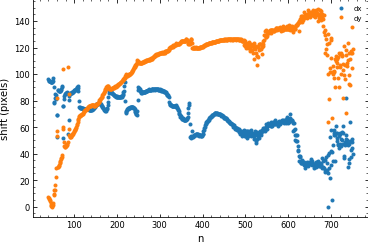

In [18]:
# Part two of step 7 of the algorithm
min_norm = widget.result
nr = np.arange(Wc.shape[0])*stride + start
coords, weightmatrix, DX, DY, row_mask = threshold_and_mask(min_norm, Wc, Mc, nr)
#Step 8 of the algorithm: reduce the shift matrix to two vectors of absolute shifts
dx, dy = calc_shift_vectors(DX, DY, weightmatrix)
plt.plot(coords, dx, '.', label='dx')
plt.plot(coords, dy, '.', label='dy')
plt.xlabel('n')
plt.ylabel('shift (pixels)')
plt.legend()

In [19]:
# Interpolate the shifts for all values not in coords
shifts = np.stack(interp_shifts(coords, [dx, dy], n=original.shape[0]), axis=1)
neededMargins = np.ceil(shifts.max(axis=0)).astype(int)
shifts = da.from_array(shifts[...,np.newaxis], chunks=(dE,-1,1))

In [20]:
#Step 9, the actual shifting of the original images
corrected = da.map_blocks(shift_block, original.rechunk({0:dE}), shifts,
                          margins=neededMargins,
                          dtype=original.dtype, 
                          chunks=(dE,
                                  original.shape[1] + neededMargins[0], 
                                  original.shape[2] + neededMargins[1]),
                         )
# Remove the extra images introduced at the end by the explicit chunk size of the map_blocks call:
corrected = corrected[:original.shape[0], ...]  

# Do an interactive viewer to inspect the results
interactive(lambda n: plot_stack(corrected, n), 
            n=widgets.IntSlider(1,0,corrected.shape[0]-1,1, continuous_update=False)
           ) 

interactive(children=(IntSlider(value=1, continuous_update=False, description='n', max=751), Output()), _dom_c…

In [79]:
# Save the results to zarr
import zarr
from numcodecs import Blosc
compressor = Blosc(cname='zstd', clevel=1, shuffle=Blosc.SHUFFLE)
corrected.to_zarr(folder + r'\Driftcorrected.zarr', overwrite=True, compressor=compressor)

In [ ]:
#Or, although parallel access to HDF5 is hard, so go single process, save to hdf5
with dask.config.set(scheduler='threads'):  
    corrected.to_hdf5(folder + r'\newDriftCorrected_gaussian_{:.1f}.h5'.format{sigma}, '/stack')